In [1]:
# 1. by color family we can see the positive key words signal

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import time
import string
import warnings

# for all NLP related operations on text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# To mock web-browser and scrap tweets
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

# To consume Twitter's API
import tweepy
from tweepy import OAuthHandler 

# To identify the sentiment of text
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.np_extractors import ConllExtractor

# ignoring all the warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# for showing all the plots inline
%matplotlib inline

#https://www.kaggle.com/amar09/sentiment-analysis-on-scrapped-tweets

In [3]:
class SeleniumClient(object):
    def __init__(self):
        #Initialization method. 
        self.chrome_options = webdriver.ChromeOptions()
        self.chrome_options.add_argument('--headless')
        self.chrome_options.add_argument('--no-sandbox')
        self.chrome_options.add_argument('--disable-setuid-sandbox')

        # you need to provide the path of chromdriver in your system
        self.browser = webdriver.Chrome('D:/chromedriver_win32/chromedriver', options=self.chrome_options)

        self.base_url = 'https://twitter.com/search?q='

    def get_tweets(self, query):
        #Function to fetch tweets. 
        try: 
            self.browser.get(self.base_url+query)
            time.sleep(2)

            body = self.browser.find_element_by_tag_name('body')

            for _ in range(3000):
                body.send_keys(Keys.PAGE_DOWN)
                time.sleep(0.3)

            timeline = self.browser.find_element_by_id('timeline')
            tweet_nodes = timeline.find_elements_by_css_selector('.tweet-text')

            return pd.DataFrame({'tweets': [tweet_node.text for tweet_node in tweet_nodes]})

        except:
            print("Selenium - An error occured while fetching tweets.")

In [4]:
access_token = '3384249591-pDP0TKrYBW9C4hg9K0wVNmXcbigBxaZMuG1DQ4y'
access_token_secret = 'W1lKGISVuEXOBz4mBNa6EdR9XrL0SAqWTRvkLOqEvgqHg'
consumer_key = 'MW8hVl0NmoiXlHH3KKIdGRJel'
consumer_secret = 'Utq3weIJvNXDiZsEjDHv5bZiXBqlA0ZVdw2lYoih4eAESmDcKQ'

In [5]:
class TwitterClient(object): 
    def __init__(self): 
        #Initialization method. 
        try: 
            # create OAuthHandler object 
            auth = OAuthHandler(consumer_key, consumer_secret) 
            # set access token and secret 
            auth.set_access_token(access_token, access_token_secret) 
            # create tweepy API object to fetch tweets 
            # add hyper parameter 'proxy' if executing from behind proxy "proxy='http://172.22.218.218:8085'"
            self.api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
            
        except tweepy.TweepError as e:
            print(f"Error: Tweeter Authentication Failed - \n{str(e)}")

    def get_tweets(self, query, maxTweets = 100):
        #Function to fetch tweets. 
        # empty list to store parsed tweets 
        tweets = [] 
        sinceId = None
        max_id = -1
        tweetCount = 0
        tweetsPerQry = 100

        while tweetCount < maxTweets:
            try:
                if (max_id <= 0):
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, count=tweetsPerQry)
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                since_id=sinceId)
                else:
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                max_id=str(max_id - 1))
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                max_id=str(max_id - 1),
                                                since_id=sinceId)
                if not new_tweets:
                    print("No more tweets found")
                    break

                for tweet in new_tweets:
                    parsed_tweet = {} 
                    parsed_tweet['tweets'] = tweet.text 

                    # appending parsed tweet to tweets list 
                    if tweet.retweet_count > 0: 
                        # if tweet has retweets, ensure that it is appended only once 
                        if parsed_tweet not in tweets: 
                            tweets.append(parsed_tweet) 
                    else: 
                        tweets.append(parsed_tweet) 
                        
                tweetCount += len(new_tweets)
                print("Downloaded {0} tweets".format(tweetCount))
                max_id = new_tweets[-1].id

            except tweepy.TweepError as e:
                # Just exit if any error
                print("Tweepy error : " + str(e))
                break
        
        return pd.DataFrame(tweets)

In [6]:
twitter_client = TwitterClient()

# calling function to get tweets
tweets_df = twitter_client.get_tweets('haircolor+texture', maxTweets=7000)
print(f'tweets_df Shape - {tweets_df.shape}')
tweets_df.head(10)

Downloaded 5 tweets
No more tweets found
tweets_df Shape - (5, 1)


,tweets
0,Before/After \n\n#Cosmo_Kait #HairByKaitlynnCh...
1,Hair feeling flat? @Keunenamerica Volume Powde...
2,Foilayage Babylights x Haircut\n.\n.\n.\n.\n.\...
3,Foilayage Babylights x Haircut\n.\n.\n.\n.\n.\...
4,Foilayage Babylights x Haircut\n.\n.\n.\n.\n.\...


In [7]:
# 2 way
def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    return 'pos' if analysis.sentiment.polarity >= 0 else 'neg'

sentiments_using_textblob = tweets_df.tweets.apply(lambda tweet: fetch_sentiment_using_textblob(tweet))
pd.DataFrame(sentiments_using_textblob.value_counts())

,tweets
pos,5


In [8]:
tweets_df['sentiment'] = sentiments_using_textblob
tweets_df.head()

,tweets,sentiment
0,Before/After \n\n#Cosmo_Kait #HairByKaitlynnCh...,pos
1,Hair feeling flat? @Keunenamerica Volume Powde...,pos
2,Foilayage Babylights x Haircut\n.\n.\n.\n.\n.\...,pos
3,Foilayage Babylights x Haircut\n.\n.\n.\n.\n.\...,pos
4,Foilayage Babylights x Haircut\n.\n.\n.\n.\n.\...,pos


In [9]:
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text 

In [10]:
tweets_df['tidy_tweets'] = np.vectorize(remove_pattern)(tweets_df['tweets'], "@[\w]*: | *RT*")
tweets_df.head(10)

,tweets,sentiment,tidy_tweets
0,Before/After \n\n#Cosmo_Kait #HairByKaitlynnCh...,pos,Before/After \n\n#Cosmo_Kait #HairByKaitlynnCh...
1,Hair feeling flat? @Keunenamerica Volume Powde...,pos,Hair feeling flat? @Keunenamerica Volume Powde...
2,Foilayage Babylights x Haircut\n.\n.\n.\n.\n.\...,pos,Foilayage Babylights x Haircut\n.\n.\n.\n.\n.\...
3,Foilayage Babylights x Haircut\n.\n.\n.\n.\n.\...,pos,Foilayage Babylights x Haircut\n.\n.\n.\n.\n.\...
4,Foilayage Babylights x Haircut\n.\n.\n.\n.\n.\...,pos,Foilayage Babylights x Haircut\n.\n.\n.\n.\n.\...


In [11]:
cleaned_tweets = []

for index, row in tweets_df.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.tidy_tweets.split() if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))

tweets_df['tidy_tweets'] = cleaned_tweets
tweets_df.head(10)

,tweets,sentiment,tidy_tweets
0,Before/After \n\n#Cosmo_Kait #HairByKaitlynnCh...,pos,Before/After #Cosmo_Kait #HairByKaitlynnChampa...
1,Hair feeling flat? @Keunenamerica Volume Powde...,pos,Hair feeling flat? @Keunenamerica Volume Powde...
2,Foilayage Babylights x Haircut\n.\n.\n.\n.\n.\...,pos,Foilayage Babylights x Haircut . . . . . #foil...
3,Foilayage Babylights x Haircut\n.\n.\n.\n.\n.\...,pos,Foilayage Babylights x Haircut . . . . . #foil...
4,Foilayage Babylights x Haircut\n.\n.\n.\n.\n.\...,pos,Foilayage Babylights x Haircut . . . . . #foil...


In [12]:
tweets_df = tweets_df[tweets_df['tidy_tweets']!='']
tweets_df.head()

,tweets,sentiment,tidy_tweets
0,Before/After \n\n#Cosmo_Kait #HairByKaitlynnCh...,pos,Before/After #Cosmo_Kait #HairByKaitlynnChampa...
1,Hair feeling flat? @Keunenamerica Volume Powde...,pos,Hair feeling flat? @Keunenamerica Volume Powde...
2,Foilayage Babylights x Haircut\n.\n.\n.\n.\n.\...,pos,Foilayage Babylights x Haircut . . . . . #foil...
3,Foilayage Babylights x Haircut\n.\n.\n.\n.\n.\...,pos,Foilayage Babylights x Haircut . . . . . #foil...
4,Foilayage Babylights x Haircut\n.\n.\n.\n.\n.\...,pos,Foilayage Babylights x Haircut . . . . . #foil...


In [13]:
tweets_df.drop_duplicates(subset=['tidy_tweets'], keep=False)
tweets_df.head()

,tweets,sentiment,tidy_tweets
0,Before/After \n\n#Cosmo_Kait #HairByKaitlynnCh...,pos,Before/After #Cosmo_Kait #HairByKaitlynnChampa...
1,Hair feeling flat? @Keunenamerica Volume Powde...,pos,Hair feeling flat? @Keunenamerica Volume Powde...
2,Foilayage Babylights x Haircut\n.\n.\n.\n.\n.\...,pos,Foilayage Babylights x Haircut . . . . . #foil...
3,Foilayage Babylights x Haircut\n.\n.\n.\n.\n.\...,pos,Foilayage Babylights x Haircut . . . . . #foil...
4,Foilayage Babylights x Haircut\n.\n.\n.\n.\n.\...,pos,Foilayage Babylights x Haircut . . . . . #foil...


In [14]:
tweets_df = tweets_df.reset_index(drop=True)
tweets_df.head()

,tweets,sentiment,tidy_tweets
0,Before/After \n\n#Cosmo_Kait #HairByKaitlynnCh...,pos,Before/After #Cosmo_Kait #HairByKaitlynnChampa...
1,Hair feeling flat? @Keunenamerica Volume Powde...,pos,Hair feeling flat? @Keunenamerica Volume Powde...
2,Foilayage Babylights x Haircut\n.\n.\n.\n.\n.\...,pos,Foilayage Babylights x Haircut . . . . . #foil...
3,Foilayage Babylights x Haircut\n.\n.\n.\n.\n.\...,pos,Foilayage Babylights x Haircut . . . . . #foil...
4,Foilayage Babylights x Haircut\n.\n.\n.\n.\n.\...,pos,Foilayage Babylights x Haircut . . . . . #foil...


In [15]:
tweets_df['absolute_tidy_tweets'] = tweets_df['tidy_tweets'].str.replace("[^a-zA-Z# ]", "")

In [16]:
tokenized_tweet = tweets_df['absolute_tidy_tweets'].apply(lambda x: x.split())
tokenized_tweet

0    [BeforeAfter, #CosmoKait, #HairByKaitlynnChamp...
1    [Hair, feeling, flat, Keunenamerica, Volume, P...
2    [Foilayage, Babylights, x, Haircut, #foilayage...
3    [Foilayage, Babylights, x, Haircut, #foilayage...
4    [Foilayage, Babylights, x, Haircut, #foilayage...
Name: absolute_tidy_tweets, dtype: object

In [17]:
for i, tokens in enumerate(tokenized_tweet):
    tokenized_tweet[i] = ' '.join(tokens)

tweets_df['absolute_tidy_tweets'] = tokenized_tweet
tweets_df.head(10)

,tweets,sentiment,tidy_tweets,absolute_tidy_tweets
0,Before/After \n\n#Cosmo_Kait #HairByKaitlynnCh...,pos,Before/After #Cosmo_Kait #HairByKaitlynnChampa...,BeforeAfter #CosmoKait #HairByKaitlynnChampagn...
1,Hair feeling flat? @Keunenamerica Volume Powde...,pos,Hair feeling flat? @Keunenamerica Volume Powde...,Hair feeling flat Keunenamerica Volume Powder ...
2,Foilayage Babylights x Haircut\n.\n.\n.\n.\n.\...,pos,Foilayage Babylights x Haircut . . . . . #foil...,Foilayage Babylights x Haircut #foilayage #bal...
3,Foilayage Babylights x Haircut\n.\n.\n.\n.\n.\...,pos,Foilayage Babylights x Haircut . . . . . #foil...,Foilayage Babylights x Haircut #foilayage #bal...
4,Foilayage Babylights x Haircut\n.\n.\n.\n.\n.\...,pos,Foilayage Babylights x Haircut . . . . . #foil...,Foilayage Babylights x Haircut #foilayage #bal...


In [18]:
class PhraseExtractHelper(object):
    def __init__(self):
        self.lemmatizer = nltk.WordNetLemmatizer()
        self.stemmer = nltk.stem.porter.PorterStemmer()
    
    def leaves(self, tree):
        """Finds NP (nounphrase) leaf nodes of a chunk tree."""
        for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
            yield subtree.leaves()

    def normalise(self, word):
        """Normalises words to lowercase and stems and lemmatizes it."""
        word = word.lower()
        # word = self.stemmer.stem_word(word) # We will loose the exact meaning of the word 
        word = self.lemmatizer.lemmatize(word)
        return word

    def acceptable_word(self, word):
        """Checks conditions for acceptable word: length, stopword. We can increase the length if we want to consider large phrase"""
        accepted = bool(3 <= len(word) <= 40
            and word.lower() not in stopwords
            and 'https' not in word.lower()
            and 'http' not in word.lower()
            and '#' not in word.lower()
            )
        return accepted

    def get_terms(self, tree):
        for leaf in self.leaves(tree):
            term = [ self.normalise(w) for w,t in leaf if self.acceptable_word(w) ]
            yield term

In [19]:
sentence_re = r'(?:(?:[A-Z])(?:.[A-Z])+.?)|(?:\w+(?:-\w+)*)|(?:\$?\d+(?:.\d+)?%?)|(?:...|)(?:[][.,;"\'?():-_`])'
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""
chunker = nltk.RegexpParser(grammar)

In [20]:
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate(all_words)

    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

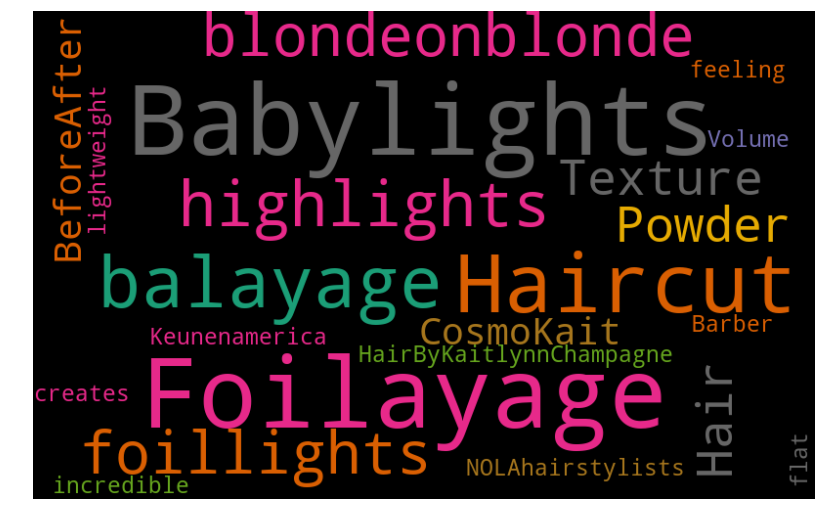

In [21]:
all_words = ' '.join([text for text in tweets_df['absolute_tidy_tweets'][tweets_df.sentiment == 'pos']])
generate_wordcloud(all_words)

In [22]:
(tweets_df)

,tweets,sentiment,tidy_tweets,absolute_tidy_tweets
0,Before/After \n\n#Cosmo_Kait #HairByKaitlynnCh...,pos,Before/After #Cosmo_Kait #HairByKaitlynnChampa...,BeforeAfter #CosmoKait #HairByKaitlynnChampagn...
1,Hair feeling flat? @Keunenamerica Volume Powde...,pos,Hair feeling flat? @Keunenamerica Volume Powde...,Hair feeling flat Keunenamerica Volume Powder ...
2,Foilayage Babylights x Haircut\n.\n.\n.\n.\n.\...,pos,Foilayage Babylights x Haircut . . . . . #foil...,Foilayage Babylights x Haircut #foilayage #bal...
3,Foilayage Babylights x Haircut\n.\n.\n.\n.\n.\...,pos,Foilayage Babylights x Haircut . . . . . #foil...,Foilayage Babylights x Haircut #foilayage #bal...
4,Foilayage Babylights x Haircut\n.\n.\n.\n.\n.\...,pos,Foilayage Babylights x Haircut . . . . . #foil...,Foilayage Babylights x Haircut #foilayage #bal...
